In [1]:
import os

# Check if the notebook is running on Colab
if 'COLAB_GPU' in os.environ:
    # This block will run only in Google Colab
    IN_COLAB = True
    print("Running on Google Colab. Cloning the repository.")
else:
    # This block will run if not in Google Colab
    IN_COLAB = False
    print("Not running on Google Colab. Assuming local environment.")

if IN_COLAB:
    from google.colab import files, drive
    drive.mount('/content/drive')

DRIVE_PATH = '/content/drive/My Drive/resnet18_slt_models/init_signed_constant/' if IN_COLAB else './'

Running on Google Colab. Cloning the repository.
Mounted at /content/drive


In [2]:

import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.autograd as autograd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Use TNR for all figures
# to match paper templates
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = [
    "Times New Roman",
] + plt.rcParams["font.serif"]

# Whitegrid is most appropriate
# for scientific papers
sns.set_style("whitegrid")

# An optional colorblind palette
# for figures
CB_color_cycle = [
    "#377EB8",
    "#FF7F00",
    "#4DAF4A",
    "#F781BF",
    "#A65628",
    "#984EA3",
    "#999999",
    "#E41A1C",
    "#DEDE00",
]

In [3]:
class StatisticsTracker:
    instance = None

    def __new__(cls):
        if cls.instance is None:
            cls.instance = super(StatisticsTracker, cls).__new__(cls)
            cls.zero_percentage = 0
            cls.one_percentage = 0
        return cls.instance

    def update(self, zeros, ones, total):
        self.zero_percentage = (zeros / total) * 100
        self.one_percentage = (ones / total) * 100

    def get_statistics(self):
        return self.zero_percentage, self.one_percentage


class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the subnetwork by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        # print("\n--------------")
        # print("J: ", j)
        # print("bottom: ", len(flat_out[idx[:j]]))
        # print("top: ", len(flat_out[idx[j:]]))
        # print("total: ", len(flat_out))
        # print("total2: ", len(flat_out[idx]))

        # Update statistics
        tracker = StatisticsTracker()
        zeros = (flat_out == 0).sum().item()
        ones = (flat_out == 1).sum().item()
        total = flat_out.numel()
        tracker.update(zeros, ones, total)

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None

class NonAffineBatchNorm(nn.BatchNorm2d):
    def __init__(self, dim):
        super(NonAffineBatchNorm, self).__init__(dim, affine=False)

class SubnetConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))
        self.prune_rate = prune_rate

    def set_prune_rate(self, prune_rate):
        self.prune_rate = prune_rate

    @property
    def clamped_scores(self):
        return self.scores.abs()

    def forward(self, x):
        subnet = GetSubnet.apply(self.clamped_scores, self.prune_rate)
        w = self.weight * subnet
        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        return x

In [4]:
batch_size = 256
test_batch_size = 1000
epochs = 100
lr = 0.1
momentum = 0.9
weight_decay = 0.0005
nesterov=False
log_interval = 10
data_path = "data"
prune_rate = 0.4
# prune_rate=0.025
save_model = True
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
last_layer_dense = True
num_class = 10
nonlinearity = "relu"
# init = "kaiming_normal"
init = "signed_constant"
mode = "fan_in"
scale_fan = False
conv_type = SubnetConv
bn_type = NonAffineBatchNorm
first_layer_type = None
first_layer_dense = True
gpu = None

In [5]:
# train_loader = torch.utils.data.DataLoader(datasets.MNIST(os.path.join(data_path, 'mnist'), train=True, download=True,
#                                                           transform=transforms.Compose([transforms.ToTensor(),
#                                                                                         transforms.Normalize((0.1307,), (0.3081,))])),
#                                            batch_size=batch_size, shuffle=True)

# test_loader = torch.utils.data.DataLoader(datasets.MNIST(os.path.join(data_path, 'mnist'), train=False,
#                                                          transform=transforms.Compose([transforms.ToTensor(),
#                                                                                        transforms.Normalize((0.1307,), (0.3081,))])),
#                                           batch_size=test_batch_size, shuffle=True)


normalize = transforms.Normalize(
            mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.262]
        )


train_set = datasets.CIFAR10(root=os.path.join(data_path, 'cifar10'),
                             train=True,
                             download=True,
                             transform=transforms.Compose(
                                                        [
                                                            transforms.RandomCrop(32, padding=4),
                                                            transforms.RandomHorizontalFlip(),
                                                            transforms.ToTensor(),
                                                            normalize,
                                                        ]
                                                    ))
test_set = datasets.CIFAR10(root=os.path.join(data_path, 'cifar10'),
                            train=False,
                            download=True,
                            transform=transforms.Compose([transforms.ToTensor(), normalize]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=False, drop_last=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 42960133.55it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


In [6]:
class Builder(object):
    def __init__(self, conv_layer, bn_layer, first_layer=None):
        self.conv_layer = conv_layer
        self.bn_layer = bn_layer
        self.first_layer = first_layer or conv_layer


    def conv(self, kernel_size, in_planes, out_planes, stride=1, first_layer=False):
        conv_layer = self.first_layer if first_layer else self.conv_layer

        if first_layer:
            print(f"==> Building first layer with {str(self.first_layer)}")

        if kernel_size == 3:
            conv = conv_layer(
                in_planes,
                out_planes,
                kernel_size=3,
                stride=stride,
                padding=1,
                bias=False,
            )
        elif kernel_size == 1:
            conv = conv_layer(
                in_planes, out_planes, kernel_size=1, stride=stride, bias=False
            )
        elif kernel_size == 5:
            conv = conv_layer(
                in_planes,
                out_planes,
                kernel_size=5,
                stride=stride,
                padding=2,
                bias=False,
            )
        elif kernel_size == 7:
            conv = conv_layer(
                in_planes,
                out_planes,
                kernel_size=7,
                stride=stride,
                padding=3,
                bias=False,
            )
        else:
            return None

        self._init_conv(conv)

        return conv


    def conv3x3(self, in_planes, out_planes, stride=1, first_layer=False):
        """3x3 convolution with padding"""
        c = self.conv(3, in_planes, out_planes, stride=stride, first_layer=first_layer)
        return c

    def conv1x1(self, in_planes, out_planes, stride=1, first_layer=False):
        """1x1 convolution with padding"""
        c = self.conv(1, in_planes, out_planes, stride=stride, first_layer=first_layer)
        return c

    def conv7x7(self, in_planes, out_planes, stride=1, first_layer=False):
        """7x7 convolution with padding"""
        c = self.conv(7, in_planes, out_planes, stride=stride, first_layer=first_layer)
        return c

    def conv5x5(self, in_planes, out_planes, stride=1, first_layer=False):
        """5x5 convolution with padding"""
        c = self.conv(5, in_planes, out_planes, stride=stride, first_layer=first_layer)
        return c

    def batchnorm(self, planes, last_bn=False, first_layer=False):
        return self.bn_layer(planes)

    def activation(self):
        if nonlinearity == "relu":
            return (lambda: nn.ReLU(inplace=True))()
        else:
            raise ValueError(f"{nonlinearity} is not an initialization option!")

    def _init_conv(self, conv):
        if init == "signed_constant":

            fan = nn.init._calculate_correct_fan(conv.weight, mode)
            if scale_fan:
                fan = fan * (1 - prune_rate)
            gain = nn.init.calculate_gain(nonlinearity)
            std = gain / math.sqrt(fan)
            conv.weight.data = conv.weight.data.sign() * std

        elif init == "unsigned_constant":

            fan = nn.init._calculate_correct_fan(conv.weight, mode)
            if scale_fan:
                fan = fan * (1 - prune_rate)

            gain = nn.init.calculate_gain(nonlinearity)
            std = gain / math.sqrt(fan)
            conv.weight.data = torch.ones_like(conv.weight.data) * std

        elif init == "kaiming_normal":

            if scale_fan:
                fan = nn.init._calculate_correct_fan(conv.weight, mode)
                fan = fan * (1 - prune_rate)
                gain = nn.init.calculate_gain(nonlinearity)
                std = gain / math.sqrt(fan)
                with torch.no_grad():
                    conv.weight.data.normal_(0, std)
            else:
                nn.init.kaiming_normal_(
                    conv.weight, mode=mode, nonlinearity=nonlinearity
                )

        elif init == "kaiming_uniform":
            nn.init.kaiming_uniform_(
                conv.weight, mode=mode, nonlinearity=nonlinearity
            )
        elif init == "xavier_normal":
            nn.init.xavier_normal_(conv.weight)
        elif init == "xavier_constant":

            fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(conv.weight)
            std = math.sqrt(2.0 / float(fan_in + fan_out))
            conv.weight.data = conv.weight.data.sign() * std

        elif init == "standard":

            nn.init.kaiming_uniform_(conv.weight, a=math.sqrt(5))

        else:
            raise ValueError(f"{init} is not an initialization option!")


def get_builder():

    print("==> Conv Type: {}".format(conv_type))
    print("==> BN Type: {}".format(bn_type))

    #conv_layer = getattr(utils.conv_type, conv_type)
    #bn_layer = getattr(utils.bn_type, bn_type)
    conv_layer = conv_type
    bn_layer = bn_type

    if first_layer_type is not None:
        first_layer = getattr(conv_type, first_layer_type)
        print(f"==> First Layer Type: {first_layer_type}")
    else:
        first_layer = None

    builder = Builder(conv_layer=conv_layer, bn_layer=bn_layer, first_layer=first_layer)
    #builder = Builder(conv_layer=None, bn_layer=None, first_layer=None)

    return builder

In [7]:

class BasicBlockCIFAR(nn.Module):
    expansion = 1

    def __init__(self, builder, in_planes, planes, stride=1):
        super(BasicBlockCIFAR, self).__init__()
        self.conv1 = builder.conv3x3(in_planes, planes, stride=stride)
        self.bn1 = builder.batchnorm(planes)
        self.conv2 = builder.conv3x3(planes, planes, stride=1)
        self.bn2 = builder.batchnorm(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                builder.conv1x1(in_planes, self.expansion * planes, stride=stride),
                builder.batchnorm(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class BottleneckCIFAR(nn.Module):
    expansion = 4

    def __init__(self, builder, in_planes, planes, stride=1):
        super(BottleneckCIFAR, self).__init__()
        self.conv1 = builder.conv1x1(in_planes, planes)
        self.bn1 = builder.batchnorm(planes)
        self.conv2 = builder.conv3x3(planes, planes, stride=stride)
        self.bn2 = builder.batchnorm(planes)
        self.conv3 = builder.conv1x1(planes, self.expansion * planes)
        self.bn3 = builder.batchnorm(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                builder.conv1x1(in_planes, self.expansion * planes, stride=stride),
                builder.batchnorm(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)

        return out


class ResNetCIFAR(nn.Module):
    def __init__(self, builder, block, num_blocks):
        super(ResNetCIFAR, self).__init__()
        self.in_planes = 64
        self.builder = builder

        self.conv1 = builder.conv3x3(3, 64, stride=1, first_layer=True)
        self.bn1 = builder.batchnorm(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        if last_layer_dense:
            self.fc = nn.Conv2d(512 * block.expansion, 10, 1)
        else:
            self.fc = builder.conv1x1(512 * block.expansion, 10)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.builder, self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = self.fc(out)
        return out.flatten(1)

In [8]:
import copy

def get_initial_weights(model):
    initial_weights = {}
    for name, param in model.named_parameters():
        if 'weight' in name:  # This checks if the parameter is a weight
            initial_weights[name] = copy.deepcopy(param.data)
    return initial_weights

def get_initial_scores(model):
    initial_scores = {}
    for name, param in model.named_parameters():
        if 'scores' in name:  # This checks if the parameter is a score
            initial_scores[name] = copy.deepcopy(param.data)
    return initial_scores

def check_weights_change(initial_weights, model):
    counter = 0
    for name, param in model.named_parameters():
        if 'weight' in name:  # Again, checking for weights
            initial_weight = initial_weights[name]
            final_weight = param.data
            # Calculate the absolute difference and check if any values are non-zero
            difference = (initial_weight - final_weight).abs().sum().item()
            if difference > 0:
                counter += 1
                # print(f"Weight '{name}' has changed by {difference}.")

    if counter == 0:
        print("No weights changed.")

def check_scores_change(initial_scores, model):
    counter = 0
    for name, param in model.named_parameters():
        if 'scores' in name:  # Checking for scores
            initial_score = initial_scores[name]
            final_score = param.data
            # Calculate the absolute difference and check if any values are non-zero
            difference = (initial_score - final_score).abs().sum().item()
            if difference > 0:
                counter += 1
                # print(f"Score '{name}' has changed by {difference}.")

    if counter == 0:
        print("No scores changed.")

In [9]:
def freeze_model_weights(model):
    print("=> Freezing model weights")

    for n, m in model.named_modules():
        if hasattr(m, "weight") and m.weight is not None:
            print(f"==> No gradient to {n}.weight")
            m.weight.requires_grad = False
            if m.weight.grad is not None:
                print(f"==> Setting gradient of {n}.weight to None")
                m.weight.grad = None

            if hasattr(m, "bias") and m.bias is not None:
                print(f"==> No gradient to {n}.bias")
                m.bias.requires_grad = False

                if m.bias.grad is not None:
                    print(f"==> Setting gradient of {n}.bias to None")
                    m.bias.grad = None


def freeze_model_subnet(model):
    print("=> Freezing model subnet")

    for n, m in model.named_modules():
        if hasattr(m, "scores"):
            m.scores.requires_grad = False
            print(f"==> No gradient to {n}.scores")
            if m.scores.grad is not None:
                print(f"==> Setting gradient of {n}.scores to None")
                m.scores.grad = None


def unfreeze_model_weights(model):
    print("=> Unfreezing model weights")

    for n, m in model.named_modules():
        if hasattr(m, "weight") and m.weight is not None:
            print(f"==> Gradient to {n}.weight")
            m.weight.requires_grad = True
            if hasattr(m, "bias") and m.bias is not None:
                print(f"==> Gradient to {n}.bias")
                m.bias.requires_grad = True


def unfreeze_model_subnet(model):
    print("=> Unfreezing model subnet")

    for n, m in model.named_modules():
        if hasattr(m, "scores"):
            print(f"==> Gradient to {n}.scores")
            m.scores.requires_grad = True


def set_model_prune_rate(model, prune_rate):
    print(f"==> Setting prune rate of network to {prune_rate}")

    for n, m in model.named_modules():
        if hasattr(m, "set_prune_rate"):
            m.set_prune_rate(prune_rate)
            print(f"==> Setting prune rate of {n} to {prune_rate}")


def get_optimizer(model):
    parameters = list(model.named_parameters())
    bn_params = [v for n, v in parameters if ("bn" in n) and v.requires_grad]
    rest_params = [v for n, v in parameters if ("bn" not in n) and v.requires_grad]
    optimizer = torch.optim.SGD(
        [
            {
                "params": bn_params,
                "weight_decay": weight_decay,
            },
            {"params": rest_params, "weight_decay": weight_decay},
        ],
        lr,
        momentum=momentum,
        weight_decay=weight_decay,
        nesterov=nesterov,
    )

    return optimizer

In [32]:
def load_model(epoch):
    checkpoint_path = os.path.join(DRIVE_PATH, f"resnet18_slt_epoch_{epoch}_30_final.pth")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model = ResNetCIFAR(get_builder(), BasicBlockCIFAR, [2,2,2,2])
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def compute_loss(model, dataloader):
    criterion = nn.CrossEntropyLoss().to(device)
    total_loss = 0.0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(dataloader)

def compute_acc(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f}%')
    return accuracy

def check_scores_in_model(model):
    has_scores = False
    for name, module in model.named_modules():
        if hasattr(module, 'scores'):
            has_scores = True
    for name, param in model.named_parameters():
        if torch.isnan(param).any():
            print(f"Parameter {name} contains NaN values.")
    return has_scores

def calculate_l2_norm_weights_scores(model1, model2):
    state_dict1 = model1.state_dict()
    state_dict2 = model2.state_dict()

    # Move parameters to CPU and ensure they are in float format for norm calculation
    state_dict1 = {k: v.cpu().float() for k, v in state_dict1.items()}
    state_dict2 = {k: v.cpu().float() for k, v in state_dict2.items()}

    l2_norm_weights = 0.0
    l2_norm_scores = 0.0

    for key in state_dict1:
        if key in state_dict2:
            if 'score' in key:  # Adjust this check based on how scores are identified
                l2_norm_scores += torch.norm(state_dict1[key] - state_dict2[key], p=2).item()**2
            else:
                l2_norm_weights += torch.norm(state_dict1[key] - state_dict2[key], p=2).item()**2

    return np.sqrt(l2_norm_weights), np.sqrt(l2_norm_scores)

def calculate_l2_norm_v2(model1, model2, k1, k2):
    state_dict1 = model1.state_dict()
    state_dict2 = model2.state_dict()

    state_dict1 = {k: v.cpu().float() for k, v in state_dict1.items()}
    state_dict2 = {k: v.cpu().float() for k, v in state_dict2.items()}

    l2_norm_top_k_weights = 0.0
    l2_norm_scores = 0.0
    for key in state_dict1:
        if key in state_dict2 and 'score' not in key:
            score_key = key.replace('weight', 'scores')

            if score_key not in state_dict1 or score_key not in state_dict2:
                continue  # Skip this iteration if scores are not available for the layer

            # Zero out weights outside the top k% based on scores for both models
            zeroed_weights_model1 = zero_outside_top_k(state_dict1[key], state_dict1[score_key], k1)
            zeroed_weights_model2 = zero_outside_top_k(state_dict2[key], state_dict2[score_key], k2)

            # Calculate the L2 norm between the zeroed weight tensors
            l2_norm_top_k_weights += torch.norm(zeroed_weights_model1 - zeroed_weights_model2, p=2).item()**2
        elif 'score' in key:
            l2_norm_scores += torch.norm(state_dict1[key] - state_dict2[key], p=2).item()**2

    return np.sqrt(l2_norm_top_k_weights), np.sqrt(l2_norm_scores)

def zero_outside_top_k(weights, scores, k):
    """Zero out weights outside the top k% based on scores."""
    out = weights.clone().flatten()
    _, idx = scores.flatten().sort(descending=True)
    j = int(len(out) * (k / 100))

    # print("Len(out): ", len(out))
    # print("k: ", k)
    # print("J: ", j)

    # Zero out weights outside the top k%
    out[idx[j:]] = 0

    return out.view(weights.size())

def compute_jaccard_similarity(model1, model2, k):
    jaccard_similarities = []
    for key in model1.state_dict():
        if 'scores' in key and key in model2.state_dict():
            scores1 = model1.state_dict()[key].cpu().flatten()
            scores2 = model2.state_dict()[key].cpu().flatten()

            _, idx1 = scores1.sort(descending=True)
            _, idx2 = scores2.sort(descending=True)

            top_k_idx1 = set(idx1[:int(len(idx1) * k)].tolist())
            top_k_idx2 = set(idx2[:int(len(idx2) * k)].tolist())

            intersection = len(top_k_idx1.intersection(top_k_idx2))
            union = len(top_k_idx1.union(top_k_idx2))

            jaccard_similarity = intersection / union if union != 0 else 0
            jaccard_similarities.append(jaccard_similarity)

    # Return the average Jaccard similarity across all layers with scores
    return sum(jaccard_similarities) / len(jaccard_similarities) if jaccard_similarities else 0

def compute_entropy_of_model_scores(model):
    entropies = []
    for key in model.state_dict():
        if 'scores' in key:
            scores = model.state_dict()[key].cpu().flatten()
            # Normalize scores to form a probability distribution
            probabilities = scores / scores.sum()
            probabilities = probabilities[probabilities > 0]  # Filter out zeros

            entropy = -(probabilities * np.log(probabilities)).sum()
            entropies.append(entropy)

    # Return the average entropy across all score layers
    return sum(entropies) / len(entropies) if entropies else 0

def compute_cosine_similarity(model1, model2):
    state_dict1 = model1.state_dict()
    state_dict2 = model2.state_dict()

    # Ensure parameters are on CPU and in floating point format for computation
    state_dict1 = {k: v.cpu().float() for k, v in state_dict1.items() if "score" not in k}
    state_dict2 = {k: v.cpu().float() for k, v in state_dict2.items() if "score" not in k}

    cosine_similarities = []

    for key in state_dict1:
        if key in state_dict2 and 'score' not in key:
            # Flatten the tensors to compute cosine similarity on them as vectors
            vec1 = state_dict1[key].view(-1)
            vec2 = state_dict2[key].view(-1)

            # Compute cosine similarity using PyTorch's functional API
            similarity = torch.nn.functional.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0), dim=1)
            cosine_similarities.append(similarity.item())

    # Calculate and return the average cosine similarity, or return None if the list is empty
    return np.mean(cosine_similarities) if cosine_similarities else None


In [33]:
l2_norms_weights = []
l2_norms_scores = []
cosine_scores = []
jaccard_scores = []
entropy_scores = []

for i in range(7, 198):
    print(i)
    model1 = load_model(i)
    model2 = load_model(i+1)

    l2_norm_weights, l2_norm_scores = calculate_l2_norm_v2(model1, model2, 30, 30)
    l2_norms_weights.append(l2_norm_weights)
    l2_norms_scores.append(l2_norm_scores)

    jaccard_similarity = compute_jaccard_similarity(model1, model2, 0.3)
    print(f"Average Jaccard Similarity Across Models: {jaccard_similarity}")
    jaccard_scores.append(jaccard_similarity)



7
==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
Average Jaccard Similarity Across Models: 0.9515660884237134
8
==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
Average Jaccard Similarity Across Models: 0.9529070720007466
9
==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNor

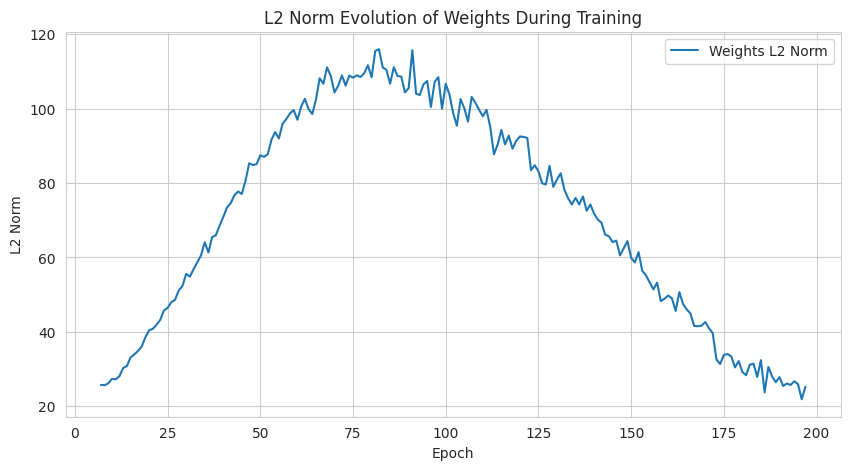

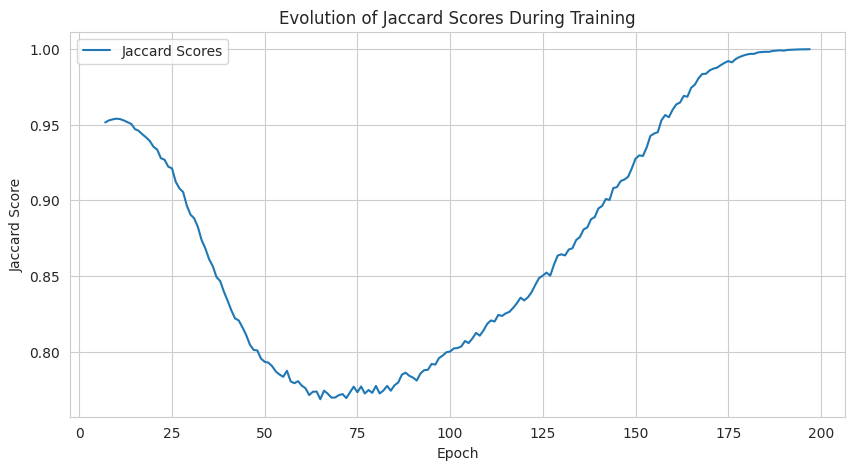

In [36]:
import matplotlib.pyplot as plt

# Plot for weights
plt.figure(figsize=(10, 5))
plt.plot(range(7, 198), l2_norms_weights, label='Weights L2 Norm')
plt.xlabel('Epoch')
plt.ylabel('L2 Norm')
plt.title('L2 Norm Evolution of Weights During Training')
plt.legend()
plt.show()

# Plot for scores
plt.figure(figsize=(10, 5))
plt.plot(range(7, 198), jaccard_scores, label='Jaccard Scores')
plt.xlabel('Epoch')
plt.ylabel('Jaccard Score')
plt.title('Evolution of Jaccard Scores During Training')
plt.legend()
plt.show()

In [13]:
import csv

epochs = range(7, 99)  # Assuming epochs start from 1

# Open (or create) the CSV file for writing
with open('l2_norm_weights_30_200.csv', mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(['Epoch', 'Score'])

    # Write the scores
    for epoch, score in zip(epochs, l2_norms_weights):
        writer.writerow([epoch, score])

with open('jaccard_scores_30_200.csv', mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(['Epoch', 'Score'])

    # Write the scores
    for epoch, score in zip(epochs, jaccard_scores):
        writer.writerow([epoch, score])

with open('entropy_scores_30_200.csv', mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(['Epoch', 'Score'])

    # Write the scores
    for epoch, score in zip(epochs, entropy_scores):
        writer.writerow([epoch, score])


In [14]:
print(len(entropy_scores))

193


In [11]:
import csv

csv_file_1 = "test_loss_30_200.csv"
with open(csv_file_1, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Test Loss"])

csv_file_2 = "test_accuracy_30_200.csv"
with open(csv_file_2, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Test Loss"])

prune_rate = 0.3
for epoch in range(100, 200):
    model = load_model(epoch)
    # Check if 'scores' are included in the loaded model
    if check_scores_in_model(model):
        print("Model contains 'scores'. Loading seems successful.")
    else:
        print("Model does NOT contain 'scores'. Check the model architecture.")

    test_loss = compute_loss(model, test_loader)
    print(f"Epoch: {epoch}, Test Loss: {test_loss}")
    with open(csv_file_1, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, test_loss])

    test_accuracy = compute_acc(model, test_loader)
    with open(csv_file_2, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, test_accuracy])

    print("\n")

==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
Model contains 'scores'. Loading seems successful.
Epoch: 100, Test Loss: 0.22323129177093506
Accuracy of the network on the 10000 test images: 93.86%


==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
Model contains 'scores'. Loading seems successful.
Epoch: 101, Test Loss: 0.2258459210395813
Accuracy of the network on the 10000 test images: 93.77%


==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
Model contains 'scores'. Loading seems successful.
Epoch: 102, Test Loss: 0.22593003660440444
Accuracy of the network on the 10000 test images: 93.75%


==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__

In [19]:
file_paths = []
percentages = []
for file_name in os.listdir(DRIVE_PATH):
    if file_name.startswith("resnet18") and file_name.endswith('.pth') and not file_name.endswith('v2.pth') and not file_name.endswith('test.pth'):
        base_name, _ = file_name.rsplit('.', 1)
        parts = base_name.split('_')
        # Check if the filename has at least 5 parts and contains 'epoch' indicating it has an epoch number and percentage
        if len(parts) > 4 and 'epoch' in parts:
            try:
                # Try to extract and convert the epoch number to an integer
                epoch = int(parts[3])  # This assumes 'epoch' is always the 4th part
                # Additional check to see if there's a percentage part after the epoch number
                percentage_str = parts[4]  # This assumes the percentage is right after the epoch number
                if percentage_str:
                    # Optionally, convert the percentage to a float to confirm it's a valid number
                    percentage = float(percentage_str)
                    # print(f"File: {file_name}, Epoch: {epoch}, Percentage: {percentage}")

                if epoch >= 6 and percentage != 30 and percentage != 2.5:
                    file_paths.append(file_name)
                    percentages.append(percentage)
                    print(f"File: {file_name}, Epoch: {epoch}, Percentage: {percentage}")
                    if epoch == 34:
                        file_paths.extend(["resnet18_slt_epoch_35_30_v2.pth",
                                          "resnet18_slt_epoch_36_30_v2.pth",
                                          "resnet18_slt_epoch_37_30_v2.pth",
                                          "resnet18_slt_epoch_38_30_v2.pth",
                                          "resnet18_slt_epoch_39_30_v2.pth"])
                        percentages.extend([30.0, 30.0, 30.0, 30.0, 30.0])
            except ValueError:
                # Handle the case where conversion to int or float fails
                pass

File: resnet18_slt_epoch_7_90.pth, Epoch: 7, Percentage: 90.0
File: resnet18_slt_epoch_8_90.pth, Epoch: 8, Percentage: 90.0
File: resnet18_slt_epoch_9_90.pth, Epoch: 9, Percentage: 90.0
File: resnet18_slt_epoch_10_80.pth, Epoch: 10, Percentage: 80.0
File: resnet18_slt_epoch_11_80.pth, Epoch: 11, Percentage: 80.0
File: resnet18_slt_epoch_12_80.pth, Epoch: 12, Percentage: 80.0
File: resnet18_slt_epoch_13_80.pth, Epoch: 13, Percentage: 80.0
File: resnet18_slt_epoch_14_80.pth, Epoch: 14, Percentage: 80.0
File: resnet18_slt_epoch_15_70.pth, Epoch: 15, Percentage: 70.0
File: resnet18_slt_epoch_16_70.pth, Epoch: 16, Percentage: 70.0
File: resnet18_slt_epoch_17_70.pth, Epoch: 17, Percentage: 70.0
File: resnet18_slt_epoch_18_70.pth, Epoch: 18, Percentage: 70.0
File: resnet18_slt_epoch_19_70.pth, Epoch: 19, Percentage: 70.0
File: resnet18_slt_epoch_20_60.pth, Epoch: 20, Percentage: 60.0
File: resnet18_slt_epoch_21_60.pth, Epoch: 21, Percentage: 60.0
File: resnet18_slt_epoch_22_60.pth, Epoch: 22,

In [20]:
for i in range(len(percentages)):
    if percentages[i] == 2.0:
        percentages[i] = 2.5

In [21]:
percentages

[90.0,
 90.0,
 90.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 70.0,
 70.0,
 70.0,
 70.0,
 70.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 20.0,
 20.0,
 20.0,
 20.0,
 20.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5]

In [22]:
def load_model_v2(path):
    print(path)
    if path.endswith('v2.pth'):
        print("Loading the 30% models.")
        checkpoint_path = path
    else:
        checkpoint_path = os.path.join(DRIVE_PATH, path)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model = ResNetCIFAR(get_builder(), BasicBlockCIFAR, [2,2,2,2])
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

l2_norms_weights = []
l2_norms_scores = []
cosine_scores = []
jaccard_scores = []

for i in range(0, len(file_paths)-1):
    print(i+7)
    model1 = load_model_v2(file_paths[i])
    model2 = load_model_v2(file_paths[i+1])

    print("Prune rate model 1: ", percentages[i])
    print("Prune rate model 2: ", percentages[i+1])
    l2_norm_weights, l2_norm_scores = calculate_l2_norm_v2(model1, model2, percentages[i], percentages[i+1])
    l2_norms_weights.append(l2_norm_weights)
    l2_norms_scores.append(l2_norm_scores)

    print("\n")


# l2_norms_weights = []
# l2_norms_scores = []
# cosine_scores = []

# for i in range(0, len(file_paths)-1):
#     model1 = load_model_v2(file_paths[i])
#     model2 = load_model_v2(file_paths[i+1])

#     l2_norm_weights = calculate_l2_norm_v2(model1, model2, percentages[i], percentages[i+1])
#     l2_norms_weights.append(l2_norm_weights)

#     cosine_sim = compute_cosine_similarity(model1, model2)
#     cosine_scores.append(cosine_sim)



7
resnet18_slt_epoch_7_90.pth
==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
resnet18_slt_epoch_8_90.pth
==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
Prune rate model 1:  90.0
Prune rate model 2:  90.0


8
resnet18_slt_epoch_8_90.pth
==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
resnet18_slt_epoch_9_90.pth
==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
Prune rate model 1:  90.0
Prune rate model 2:  90.0


9
resnet18_slt_epoch_9_90.pth
==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer w

In [25]:
import csv

csv_file_1 = "test_loss_decay.csv"
with open(csv_file_1, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Test Loss"])

csv_file_2 = "test_accuracy_decay.csv"
with open(csv_file_2, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Test Loss"])

# prune_rate = 0.4
for i in range(0, len(file_paths)):
    print(i+7)

    prune_rate = percentages[i] / 100
    print("Prune Rate: ", prune_rate)
    model = load_model_v2(file_paths[i])
    # Check if 'scores' are included in the loaded model
    if check_scores_in_model(model):
        print("Model contains 'scores'. Loading seems successful.")
    else:
        print("Model does NOT contain 'scores'. Check the model architecture.")

    test_loss = compute_loss(model, test_loader)
    print(f"Epoch: {epoch}, Test Loss: {test_loss}")
    with open(csv_file_1, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, test_loss])

    test_accuracy = compute_acc(model, test_loader)
    with open(csv_file_2, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, test_accuracy])

    print("\n")

7
Prune Rate:  0.9
resnet18_slt_epoch_7_90.pth
==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
Model contains 'scores'. Loading seems successful.
Epoch: 153, Test Loss: 1.444909691810608
Accuracy of the network on the 10000 test images: 47.53%


8
Prune Rate:  0.9
resnet18_slt_epoch_8_90.pth
==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
Model contains 'scores'. Loading seems successful.
Epoch: 153, Test Loss: 1.521861970424652
Accuracy of the network on the 10000 test images: 49.08%


9
Prune Rate:  0.9
resnet18_slt_epoch_9_90.pth
==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>
Model contains 'scores'. Loading seems successful.
Epoch: 153, Test Loss: 1.3066942572593

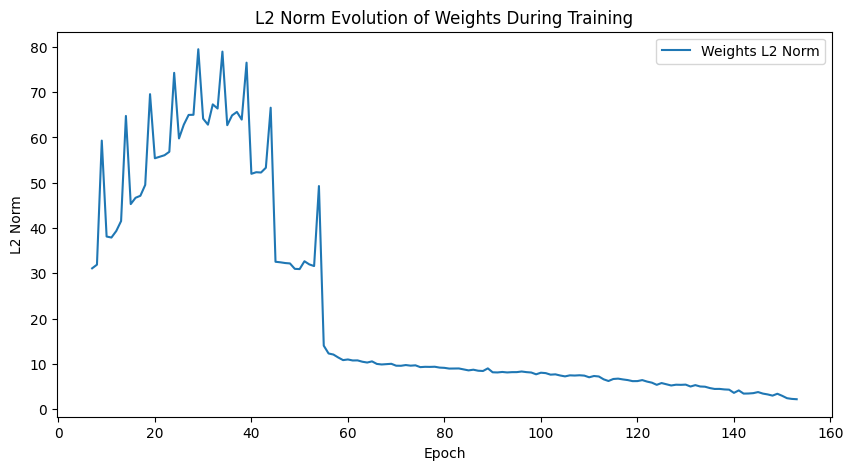

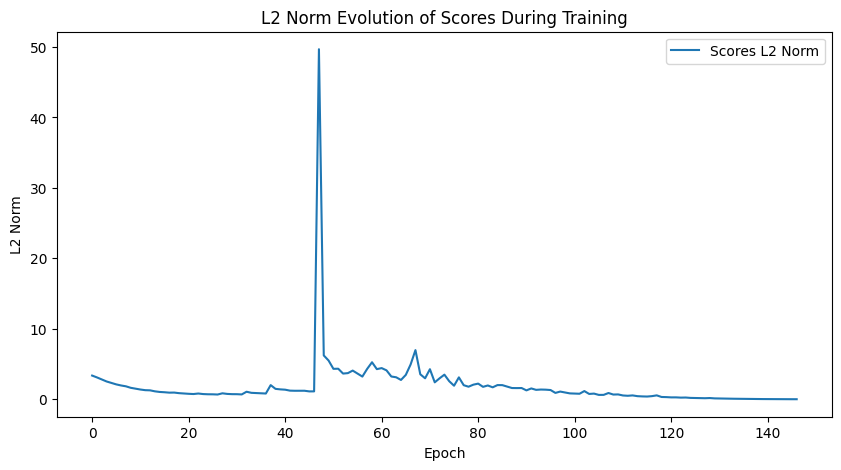

In [23]:
import matplotlib.pyplot as plt

# Plot for weights
plt.figure(figsize=(10, 5))
plt.plot(range(7, len(l2_norms_weights)+7), l2_norms_weights, label='Weights L2 Norm')
plt.xlabel('Epoch')
plt.ylabel('L2 Norm')
plt.title('L2 Norm Evolution of Weights During Training')
plt.legend()
plt.show()

# Plot for scores
plt.figure(figsize=(10, 5))
plt.plot(range(0, len(l2_norms_scores)), l2_norms_scores, label='Scores L2 Norm')
plt.xlabel('Epoch')
plt.ylabel('L2 Norm')
plt.title('L2 Norm Evolution of Scores During Training')
plt.legend()
plt.show()

# Plot for scores
# plt.figure(figsize=(10, 5))
# plt.plot(range(0, len(l2_norms_scores)), cosine_scores, label='Scores Cosince Similarity')
# plt.xlabel('Epoch')
# plt.ylabel('Cosince Similarity')
# plt.title('Cosince Similarity Evolution of Scores During Training')
# plt.legend()
# plt.show()

In [24]:
import csv

epochs = range(7, len(l2_norms_weights)+7)  # Assuming epochs start from 1

# Open (or create) the CSV file for writing
with open('l2_norm_weights_decay.csv', mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(['Epoch', 'Score'])

    # Write the scores
    for epoch, score in zip(epochs, l2_norms_weights):
        writer.writerow([epoch, score])

with open('l2_norm_scores_decay.csv', mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(['Epoch', 'Score'])

    # Write the scores
    for epoch, score in zip(epochs, jaccard_scores):
        writer.writerow([epoch, score])


In [17]:
def convert_tensor_string_to_float(tensor_string):
    """
    Converts a string representation of a tensor to a float.
    Example input: 'tensor(0.1234)'
    """
    try:
        return float(tensor_string.strip('tensor()'))
    except ValueError:
        return None

In [11]:
tableau20 = [(214, 39, 40), (255, 127, 14), (44, 160, 44), (31, 119, 180),
             (148, 103, 189), (140, 86, 75), (227, 119, 194), (127, 127, 127),
             (188, 189, 34), (23, 190, 207)]

for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [12]:
df_jaccard_25 = pd.read_csv("jaccard_scores_2.5.csv")
df_jaccard_30 = pd.read_csv("jaccard_scores_30.csv")
df_jaccard_40 = pd.read_csv("jaccard_scores_40.csv")
df_jaccard_80 = pd.read_csv("jaccard_scores_80.csv")
df_jaccard_5 = pd.read_csv("jaccard_scores_5.csv")

# Prepare the data
epochs = range(7, len(df_jaccard_25['Jaccard_Score'])+7)  # Assuming all dataframes have the same length
df_jaccard_25['Epoch'] = epochs
df_jaccard_25['Label'] = "2.5% of Weights"
df_jaccard_25.rename(columns={'Jaccard_Score': 'Score'}, inplace=True)

df_jaccard_5['Epoch'] = epochs
df_jaccard_5['Label'] = "5% of Weights"

df_jaccard_30['Epoch'] = epochs
df_jaccard_30['Label'] = "30% of Weights"

df_jaccard_40['Epoch'] = epochs
df_jaccard_40['Label'] = "40% of Weights"

# Combine into a single DataFrame
df_combined_jaccard = pd.concat([df_jaccard_25[['Epoch', 'Score', 'Label']],
                         df_jaccard_5[['Epoch', 'Score', 'Label']],
                         df_jaccard_30[['Epoch', 'Score', 'Label']],
                         df_jaccard_40[['Epoch', 'Score', 'Label']]])

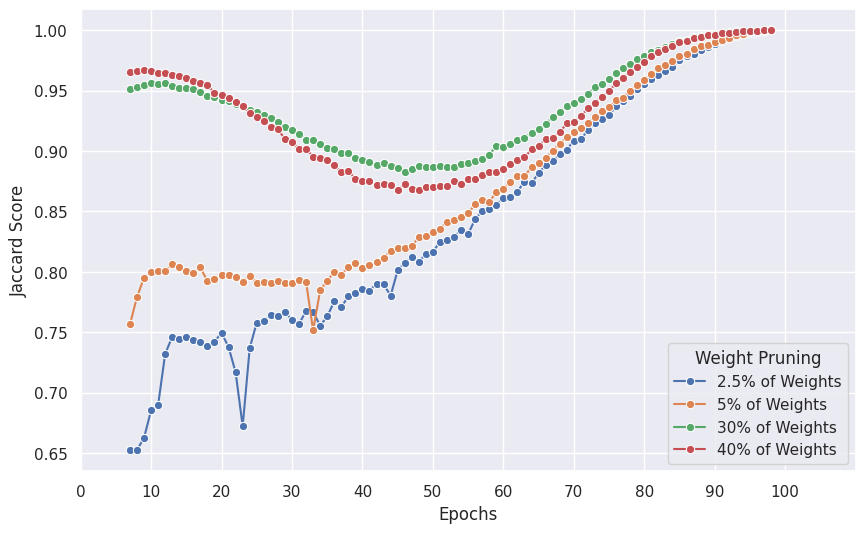

In [28]:
# Now, plot with Seaborn
sns.set_theme()  # Use Seaborn's default theme
plt.figure(figsize=(10, 6))  # Set the figure size
sns.lineplot(data=df_combined_jaccard, x='Epoch', y='Score', hue='Label', marker='o')
plt.xlim((7,110))
plt.xticks(np.arange(0, 110, 10))
plt.xlabel("Epochs")
plt.ylabel("Jaccard Score")
plt.legend(title='Weight Pruning')
plt.show()

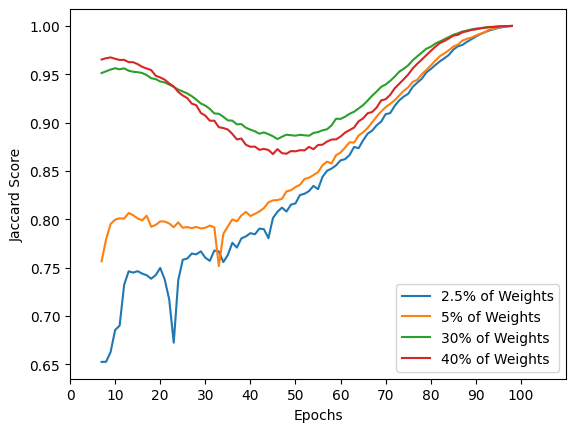

In [19]:
plt.plot(range(7, len(df_jaccard_25['Jaccard_Score'])+7), df_jaccard_25['Jaccard_Score'], color=tableau20[0], label="2.5% of Weights")
plt.plot(range(7, len(df_jaccard_5['Score'])+7), df_jaccard_5['Score'], color=tableau20[1], label="5% of Weights")
plt.plot(range(7, len(df_jaccard_30['Score'])+7), df_jaccard_30['Score'], color=tableau20[2], label="30% of Weights")
plt.plot(range(7, len(df_jaccard_40['Score'])+7), df_jaccard_40['Score'], color=tableau20[3], label="40% of Weights")

# plt.plot(agp_sparsity, rewind_agp_accuracy,"g", marker='v', markersize=5, label="AGP")
# plt.plot(onecycle_sparsity, rewind_onecycle_accuracy,"b", marker='o', markersize=5, label="one-cycle")
# plt.plot(np.linspace(0, 90, 11),np.ones(11)*90.57, linestyle="--", color="k")
plt.legend()
plt.xlim((7,110))
plt.xticks(np.arange(0,110,10))
# plt.ylim((89.7,91))
plt.xlabel("Epochs")
plt.ylabel("Jaccard Score")
plt.show()

In [13]:
df_l2_norm_weights_25 = pd.read_csv("l2_norm_weights_2.5.csv")
df_l2_norm_weights_30 = pd.read_csv("l2_norm_weights_30.csv")
df_l2_norm_weights_40 = pd.read_csv("l2_norm_weights_40.csv")
df_l2_norm_weights_80 = pd.read_csv("l2_norm_weights_80.csv")
df_l2_norm_weights_5 = pd.read_csv("l2_norm_weights_5.csv")

epochs = range(7, len(df_l2_norm_weights_25['L2_Norm_Weights'])+7)
df_l2_norm_weights_25['Epoch'] = epochs[:len(df_l2_norm_weights_25['L2_Norm_Weights'])]
df_l2_norm_weights_25['Label'] = "2.5% of Weights"
df_l2_norm_weights_25.rename(columns={'L2_Norm_Weights': 'Score'}, inplace=True)

df_l2_norm_weights_5['Epoch'] = epochs[:len(df_l2_norm_weights_5['Score'])]
df_l2_norm_weights_5['Label'] = "5% of Weights"

df_l2_norm_weights_30['Epoch'] = epochs[:len(df_l2_norm_weights_30['Score'])]
df_l2_norm_weights_30['Label'] = "30% of Weights"

df_l2_norm_weights_40['Epoch'] = epochs[:len(df_l2_norm_weights_40['Score'])]
df_l2_norm_weights_40['Label'] = "40% of Weights"

# Combine into a single DataFrame
df_combined_l2_norm_weights = pd.concat([df_l2_norm_weights_25[['Epoch', 'Score', 'Label']],
                         df_l2_norm_weights_5[['Epoch', 'Score', 'Label']],
                         df_l2_norm_weights_30[['Epoch', 'Score', 'Label']],
                         df_l2_norm_weights_40[['Epoch', 'Score', 'Label']]])

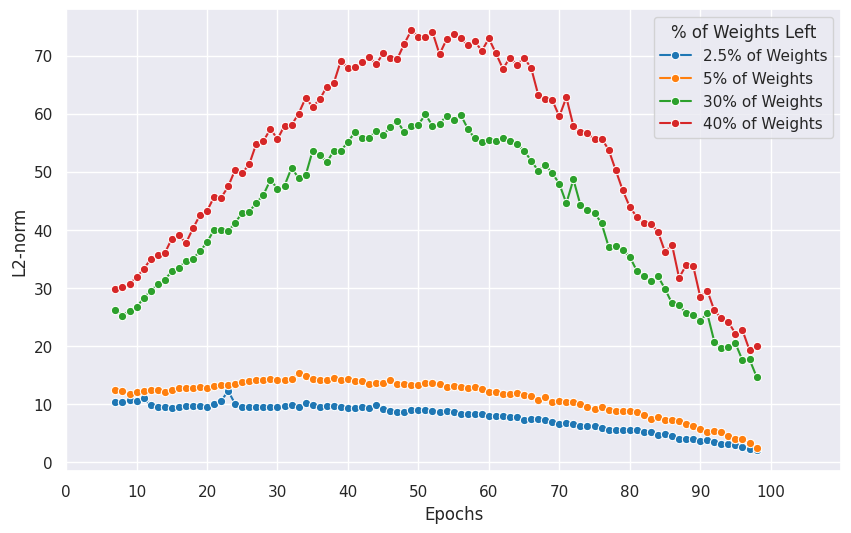

In [44]:
sns.set_theme()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_combined_l2_norm_weights, x='Epoch', y='Score', hue='Label', palette='tab10', marker='o')
plt.xlim((7,110))
plt.xticks(np.arange(0, 110, 10))
plt.xlabel("Epochs")
plt.ylabel("L2-norm")
plt.legend(title='% of Weights Left')
plt.show()

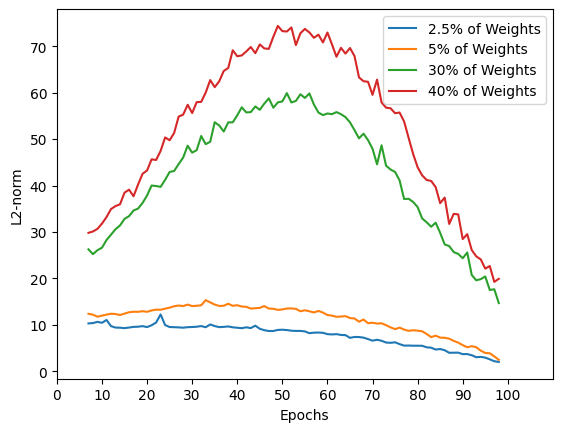

In [23]:
plt.plot(range(7, len(df_l2_norm_weights_25['L2_Norm_Weights'])+7), df_l2_norm_weights_25['L2_Norm_Weights'], color=tableau20[0], label="2.5% of Weights")
plt.plot(range(7, len(df_l2_norm_weights_5['Score'])+7), df_l2_norm_weights_5['Score'],color=tableau20[1], label="5% of Weights")
plt.plot(range(7, len(df_l2_norm_weights_30['Score'])+7), df_l2_norm_weights_30['Score'],color=tableau20[2], label="30% of Weights")
plt.plot(range(7, len(df_l2_norm_weights_40['Score'])+7), df_l2_norm_weights_40['Score'],color=tableau20[3], label="40% of Weights")
# plt.plot(range(7, len(df_l2_norm_weights_80['Score'])+7), df_l2_norm_weights_80['Score'],color=tableau20[4], label="80% of Weights")

# plt.plot(agp_sparsity, rewind_agp_accuracy,"g", marker='v', markersize=5, label="AGP")
# plt.plot(onecycle_sparsity, rewind_onecycle_accuracy,"b", marker='o', markersize=5, label="one-cycle")
# plt.plot(np.linspace(0, 90, 11),np.ones(11)*90.57, linestyle="--", color="k")
plt.legend()
plt.xlim((7,110))
plt.xticks(np.arange(0,110,10))
# plt.ylim((89.7,91))
plt.xlabel("Epochs")
plt.ylabel("L2-norm")
plt.show()

In [24]:
df_test_loss_25 = pd.read_csv("test_loss_2.5.csv")
df_test_loss_30 = pd.read_csv("test_loss_30.csv")
df_test_loss_40 = pd.read_csv("test_loss_40.csv")
df_test_loss_80 = pd.read_csv("test_loss_80.csv")
df_test_loss_5 = pd.read_csv("test_loss_5.csv")

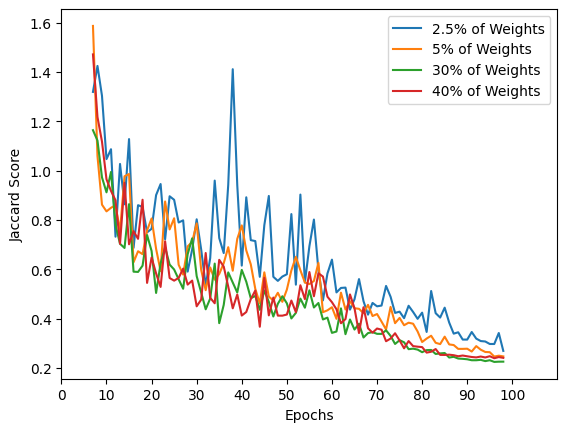

In [28]:
plt.plot(range(7, len(df_test_loss_25['Test Loss'])+7), df_test_loss_25['Test Loss'],color=tableau20[0], label="2.5% of Weights")
plt.plot(range(7, len(df_test_loss_5['Test Loss'])+7), df_test_loss_5['Test Loss'],color=tableau20[1], label="5% of Weights")
plt.plot(range(7, len(df_test_loss_30['Test Loss'])+7), df_test_loss_30['Test Loss'],color=tableau20[2], label="30% of Weights")
plt.plot(range(7, len(df_test_loss_40['Test Loss'])+7), df_test_loss_40['Test Loss'],color=tableau20[3], label="40% of Weights")
# plt.plot(range(7, len(df_test_loss_30_200['Test Loss'])+7), df_test_loss_30_200['Test Loss'],color=tableau20[4], label="40% of Weights")

# plt.plot(range(7, len(df_test_accuracy_80['Test Loss'])+7), df_test_accuracy_80['Test Loss'],"y", label="80% of Weights")

# plt.plot(agp_sparsity, rewind_agp_accuracy,"g", marker='v', markersize=5, label="AGP")
# plt.plot(onecycle_sparsity, rewind_onecycle_accuracy,"b", marker='o', markersize=5, label="one-cycle")
# plt.plot(np.linspace(0, 90, 11),np.ones(11)*90.57, linestyle="--", color="k")
# plt.yscale('log')
plt.legend()
plt.xlim((7,110))
plt.xticks(np.arange(0,110,10))
# plt.ylim((89.7,91))
plt.xlabel("Epochs")
plt.ylabel("Jaccard Score")
plt.show()

In [14]:
df_test_accuracy_25 = pd.read_csv("test_accuracy_2.5.csv")
df_test_accuracy_30 = pd.read_csv("test_accuracy_30.csv")
df_test_accuracy_40 = pd.read_csv("test_accuracy_40.csv")
df_test_accuracy_80 = pd.read_csv("test_accuracy_80.csv")
df_test_accuracy_5 = pd.read_csv("test_accuracy_5.csv")
df_test_accuracy_5['Test Loss'] = df_test_accuracy_5['Test Loss']


epochs = range(7, len(df_test_accuracy_25['Test Loss'])+7)
df_test_accuracy_25['Epoch'] = epochs[:len(df_test_accuracy_25['Test Loss'])]
df_test_accuracy_25['Label'] = "2.5% of Weights"
# df_test_accuracy_25.rename(columns={'Test Loss': 'Score'}, inplace=True)

df_test_accuracy_5['Epoch'] = epochs[:len(df_test_accuracy_5['Test Loss'])]
df_test_accuracy_5['Label'] = "5% of Weights"

df_test_accuracy_30['Epoch'] = epochs[:len(df_test_accuracy_30['Test Loss'])]
df_test_accuracy_30['Label'] = "30% of Weights"

df_test_accuracy_40['Epoch'] = epochs[:len(df_test_accuracy_40['Test Loss'])]
df_test_accuracy_40['Label'] = "40% of Weights"

# Combine into a single DataFrame
df_combined_test_accuracy = pd.concat([df_test_accuracy_25[['Epoch', 'Test Loss', 'Label']],
                         df_test_accuracy_5[['Epoch', 'Test Loss', 'Label']],
                         df_test_accuracy_30[['Epoch', 'Test Loss', 'Label']],
                         df_test_accuracy_40[['Epoch', 'Test Loss', 'Label']]])

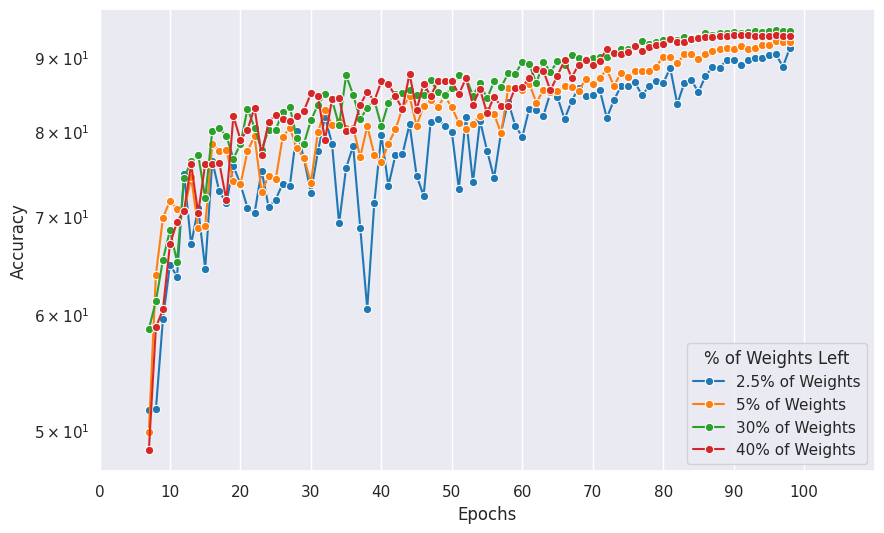

In [41]:
sns.set_theme()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_combined_test_accuracy, x='Epoch', y='Test Loss', hue='Label', palette='tab10', marker='o')
plt.xlim((7,110))
plt.xticks(np.arange(0, 110, 10))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.yscale('log')
plt.legend(title='% of Weights Left')
plt.show()

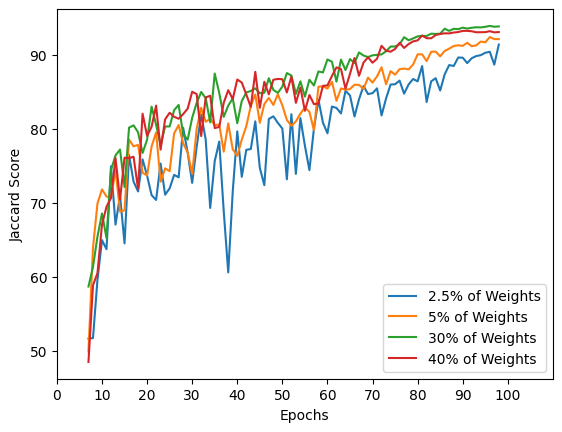

In [31]:
plt.plot(range(7, len(df_test_accuracy_25['Test Loss'])+7), df_test_accuracy_25['Test Loss'],color=tableau20[0], label="2.5% of Weights")
plt.plot(range(7, len(df_test_accuracy_5['Test Loss'])+7), df_test_accuracy_5['Test Loss'],color=tableau20[1], label="5% of Weights")
plt.plot(range(7, len(df_test_accuracy_30['Test Loss'])+7), df_test_accuracy_30['Test Loss'],color=tableau20[2], label="30% of Weights")
plt.plot(range(7, len(df_test_accuracy_40['Test Loss'])+7), df_test_accuracy_40['Test Loss'],color=tableau20[3], label="40% of Weights")
# plt.plot(range(7, len(df_test_loss_30_200['Test Loss'])+7), df_test_loss_30_200['Test Loss'],color=tableau20[4], label="40% of Weights")

# plt.plot(range(7, len(df_test_accuracy_80['Test Loss'])+7), df_test_accuracy_80['Test Loss'],"y", label="80% of Weights")

# plt.plot(agp_sparsity, rewind_agp_accuracy,"g", marker='v', markersize=5, label="AGP")
# plt.plot(onecycle_sparsity, rewind_onecycle_accuracy,"b", marker='o', markersize=5, label="one-cycle")
# plt.plot(np.linspace(0, 90, 11),np.ones(11)*90.57, linestyle="--", color="k")
# plt.yscale('log')
plt.legend()
plt.xlim((7,110))
plt.xticks(np.arange(0,110,10))
# plt.ylim((89.7,91))
plt.xlabel("Epochs")
plt.ylabel("Jaccard Score")
plt.show()

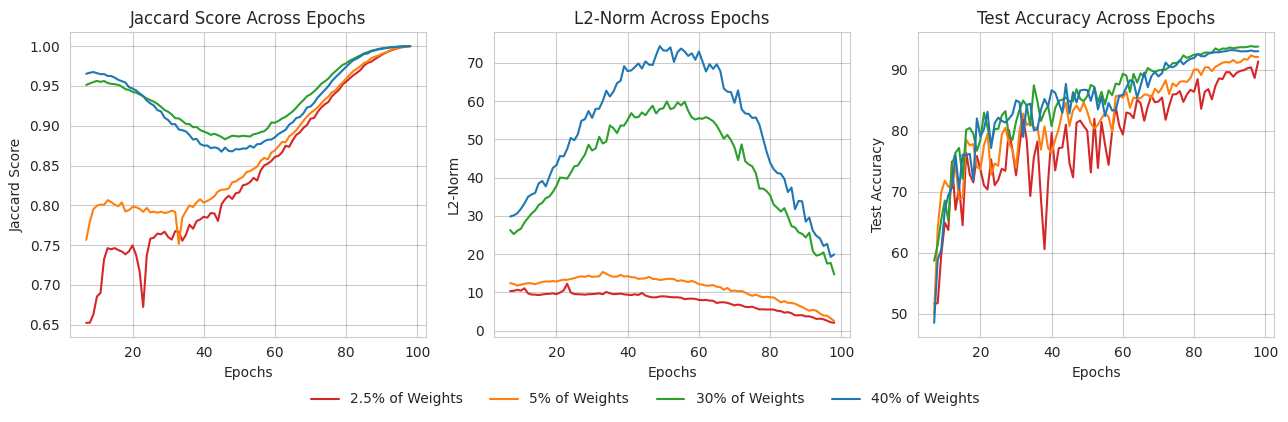

In [30]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Assuming df_jaccard_xx and df_l2_norm_weights_xx are your DataFrames with the data.
# tableau20 is assumed to be a list of color hex codes.

# Create a figure and a set of subplots
fig = plt.figure(figsize=(13, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # The third column for the legend

# Jaccard Score Plot
ax1 = plt.subplot(gs[0])
# sns.lineplot(data=df_combined_jaccard, x='Epoch', y='Score', hue='Label', palette='tab10', marker='o', ax=ax1, legend=None)
ax1.plot(range(7, len(df_jaccard_25['Score'])+7), df_jaccard_25['Score'], color=tableau20[0], label="2.5% of Weights")
ax1.plot(range(7, len(df_jaccard_5['Score'])+7), df_jaccard_5['Score'], color=tableau20[1], label="5% of Weights")
ax1.plot(range(7, len(df_jaccard_30['Score'])+7), df_jaccard_30['Score'], color=tableau20[2], label="30% of Weights")
ax1.plot(range(7, len(df_jaccard_40['Score'])+7), df_jaccard_40['Score'], color=tableau20[3], label="40% of Weights")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Jaccard Score")
ax1.set_title("Jaccard Score Across Epochs")
ax1.grid(color='k', linestyle='-', alpha=0.2)

# L2 Norm Plot
ax2 = plt.subplot(gs[1])
# sns.lineplot(data=df_combined_l2_norm_weights, x='Epoch', y='Score', hue='Label', palette='tab10', marker='o', ax=ax2, legend=None)
ax2.plot(range(7, len(df_l2_norm_weights_25['Score'])+7), df_l2_norm_weights_25['Score'], color=tableau20[0], label="2.5% of Weights")
ax2.plot(range(7, len(df_l2_norm_weights_5['Score'])+7), df_l2_norm_weights_5['Score'], color=tableau20[1], label="5% of Weights")
ax2.plot(range(7, len(df_l2_norm_weights_30['Score'])+7), df_l2_norm_weights_30['Score'], color=tableau20[2], label="30% of Weights")
ax2.plot(range(7, len(df_l2_norm_weights_40['Score'])+7), df_l2_norm_weights_40['Score'], color=tableau20[3], label="40% of Weights")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("L2-Norm")
ax2.set_title("L2-Norm Across Epochs")
ax2.grid(color='k', linestyle='-', alpha=0.2)

# Accuracy Plot
ax3 = plt.subplot(gs[2])
# sns.lineplot(data=df_combined_test_accuracy, x='Epoch', y='Test Loss', hue='Label', palette='tab10', marker='o', ax=ax3, legend=None)
ax3.plot(range(7, len(df_test_accuracy_25['Test Loss'])+7), df_test_accuracy_25['Test Loss'],color=tableau20[0], label="2.5% of Weights")
ax3.plot(range(7, len(df_test_accuracy_5['Test Loss'])+7), df_test_accuracy_5['Test Loss'],color=tableau20[1], label="5% of Weights")
ax3.plot(range(7, len(df_test_accuracy_30['Test Loss'])+7), df_test_accuracy_30['Test Loss'],color=tableau20[2], label="30% of Weights")
ax3.plot(range(7, len(df_test_accuracy_40['Test Loss'])+7), df_test_accuracy_40['Test Loss'],color=tableau20[3], label="40% of Weights")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Test Accuracy")
ax3.set_title("Test Accuracy Across Epochs")
# ax3.set_yscale('log')
ax3.grid(color='k', linestyle='-', alpha=0.2)


# Legend
# ax4 = plt.subplot(gs[3])
# ax4.axis('off')  # Hide axis
handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='center right', ncol=1, bbox_to_anchor=(1, 0.5))
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.06), ncol=4, frameon=False)

# Adjust layout for a better fit
plt.tight_layout()

# Show plot
plt.show()


In [27]:
df_test_accuracy_30_200 = pd.read_csv("test_accuracy_30_200.csv")
df_test_accuracy_30_200 = pd.concat([df_test_accuracy_30, df_test_accuracy_30_200], axis=0).reset_index(drop=True)

df_l2_norm_weights_30_200 = pd.read_csv("l2_norm_weights_30_200.csv")
df_l2_norm_weights_30_200 = pd.concat([df_l2_norm_weights_30, df_l2_norm_weights_30_200], axis=0).reset_index(drop=True)

df_jaccard_30_200 = pd.read_csv("jaccard_scores_30_200.csv")
df_jaccard_30_200 = pd.concat([df_jaccard_30, df_jaccard_30_200], axis=0).reset_index(drop=True)

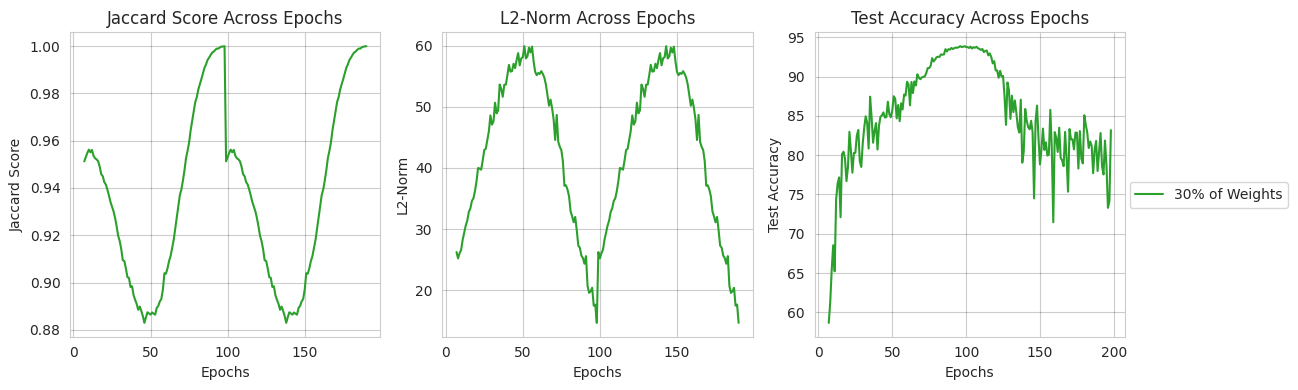

In [59]:
# Create a figure and a set of subplots
fig = plt.figure(figsize=(13, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.3])  # The third column for the legend

# Jaccard Score Plot
ax1 = plt.subplot(gs[0])
# sns.lineplot(data=df_combined_jaccard, x='Epoch', y='Score', hue='Label', palette='tab10', marker='o', ax=ax1, legend=None)
ax1.plot(range(7, len(df_jaccard_30_200['Score'])+7), df_jaccard_30_200['Score'], color=tableau20[2], label="30% of Weights")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Jaccard Score")
ax1.set_title("Jaccard Score Across Epochs")
ax1.grid(color='k', linestyle='-', alpha=0.2)

# L2 Norm Plot
ax2 = plt.subplot(gs[1])
# sns.lineplot(data=df_combined_l2_norm_weights, x='Epoch', y='Score', hue='Label', palette='tab10', marker='o', ax=ax2, legend=None)
ax2.plot(range(7, len(df_l2_norm_weights_30_200['Score'])+7), df_l2_norm_weights_30_200['Score'], color=tableau20[2], label="30% of Weights")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("L2-Norm")
ax2.set_title("L2-Norm Across Epochs")
ax2.grid(color='k', linestyle='-', alpha=0.2)

# Accuracy Plot
ax3 = plt.subplot(gs[2])
# sns.lineplot(data=df_combined_test_accuracy, x='Epoch', y='Test Loss', hue='Label', palette='tab10', marker='o', ax=ax3, legend=None)
ax3.plot(range(7, len(df_test_accuracy_30_200['Test Loss'])+7), df_test_accuracy_30_200['Test Loss'],color=tableau20[2], label="30% of Weights")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Test Accuracy")
ax3.set_title("Test Accuracy Across Epochs")
# ax3.set_yscale('log')
ax3.grid(color='k', linestyle='-', alpha=0.2)


# Legend
ax4 = plt.subplot(gs[3])
ax4.axis('off')  # Hide axis
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', ncol=1, bbox_to_anchor=(1, 0.5))

# Adjust layout for a better fit
plt.tight_layout()

# Show plot
plt.show()

In [27]:
df_test_accuracy_decay = pd.read_csv("test_accuracy_decay.csv")
df_l2_norm_weights_decay = pd.read_csv("l2_norm_weights_decay.csv")

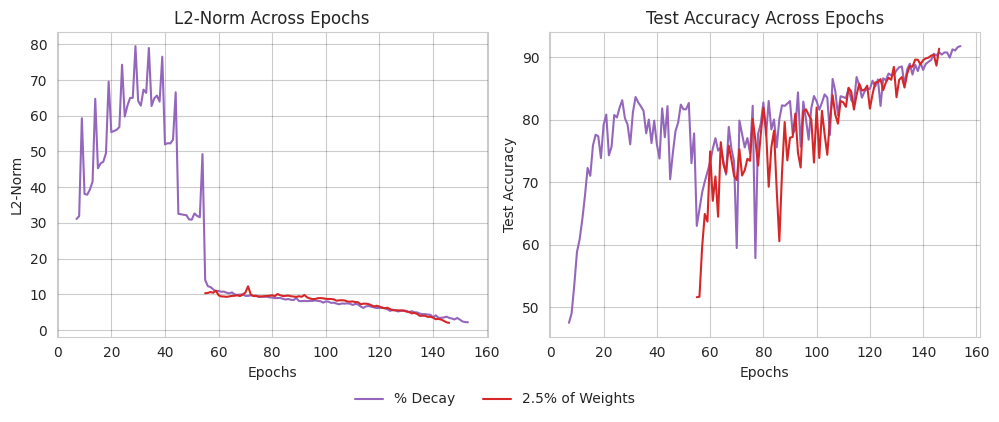

In [31]:
# Create a figure and a set of subplots
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # The third column for the legend

# L2 Norm Plot
ax1 = plt.subplot(gs[0])
# sns.lineplot(data=df_combined_l2_norm_weights, x='Epoch', y='Score', hue='Label', palette='tab10', marker='o', ax=ax2, legend=None)
ax1.plot(range(7, len(df_l2_norm_weights_decay['Score'])+7), df_l2_norm_weights_decay['Score'], color=tableau20[4], label="% Decay")
ax1.plot(range(55, len(df_l2_norm_weights_25['Score'])+55), df_l2_norm_weights_25['Score'], color=tableau20[0], label="2.5% of Weights")

ax1.set_xlabel("Epochs")
ax1.set_ylabel("L2-Norm")
ax1.set_title("L2-Norm Across Epochs")
ax1.grid(color='k', linestyle='-', alpha=0.2)

# Accuracy Plot
ax2 = plt.subplot(gs[1])
# sns.lineplot(data=df_combined_test_accuracy, x='Epoch', y='Test Loss', hue='Label', palette='tab10', marker='o', ax=ax3, legend=None)
ax2.plot(range(7, len(df_test_accuracy_decay['Test Loss'])+7), df_test_accuracy_decay['Test Loss'],color=tableau20[4], label="% Decay")
ax2.plot(range(55, len(df_test_accuracy_25['Test Loss'])+55), df_test_accuracy_25['Test Loss'], color=tableau20[0], label="2.5% of Weights")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Test Accuracy")
ax2.set_title("Test Accuracy Across Epochs")
# ax3.set_yscale('log')
ax2.grid(color='k', linestyle='-', alpha=0.2)


# Legend
# ax3 = plt.subplot(gs[2])
# ax3.axis('off')  # Hide axis
handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='center right', ncol=1, bbox_to_anchor=(1, 0.5))
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.06), ncol=2, frameon=False)

# Adjust layout for a better fit
plt.tight_layout()

# Show plot
plt.show()